In [23]:
#  Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [24]:
#  Step 2: Load the Dataset
df = pd.read_csv('online_retail_II.csv') 
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [25]:
#Step 3: Data Cleaning
df = df[df['Customer ID'].notnull()]
df = df[df['Quantity'] > 0]
df = df[df['Price'] > 0]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['Price']


In [26]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [27]:
#  Step 4: RFM Feature Engineering
snapshot_date = df['InvoiceDate'].max() + timedelta(days=1)
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm = rfm[(rfm['Monetary'] > 0)]

In [28]:
#  Step 5: RFM Segmentation
rfm['R_rank'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
rfm['F_rank'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M_rank'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])
rfm['RFM_Score'] = rfm['R_rank'].astype(str) + rfm['F_rank'].astype(str) + rfm['M_rank'].astype(str)


In [29]:
#  Step 6: Clustering with KMeans
features = rfm[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [30]:
# Find optimal K using the Elbow Method
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(features_scaled)
    sse[k] = kmeans.inertia_

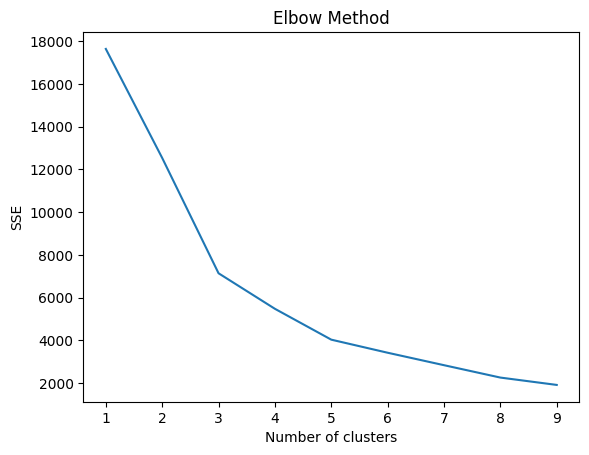

In [31]:
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("Elbow Method")
plt.show()

In [32]:
# Fit final model
kmeans = KMeans(n_clusters=4, random_state=1)
rfm['Cluster'] = kmeans.fit_predict(features_scaled)

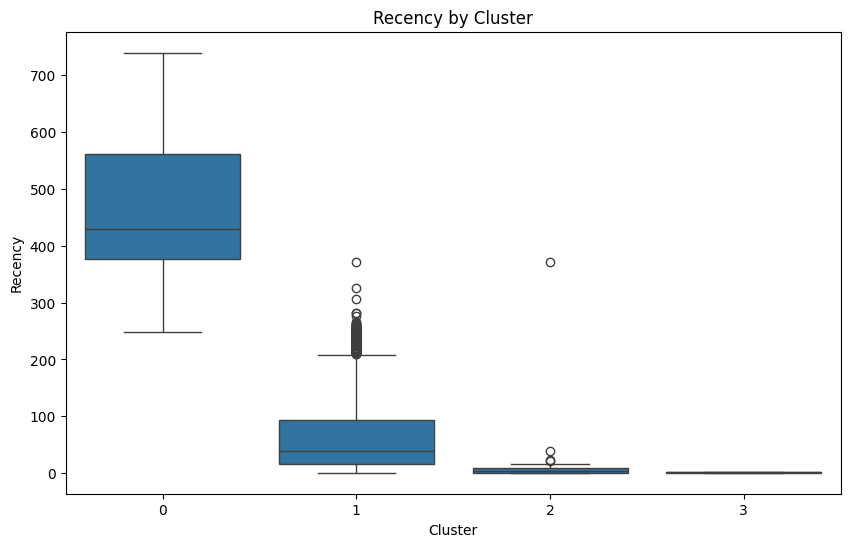

In [33]:
#  Step 7: Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Recency', data=rfm)
plt.title('Recency by Cluster')
plt.show()

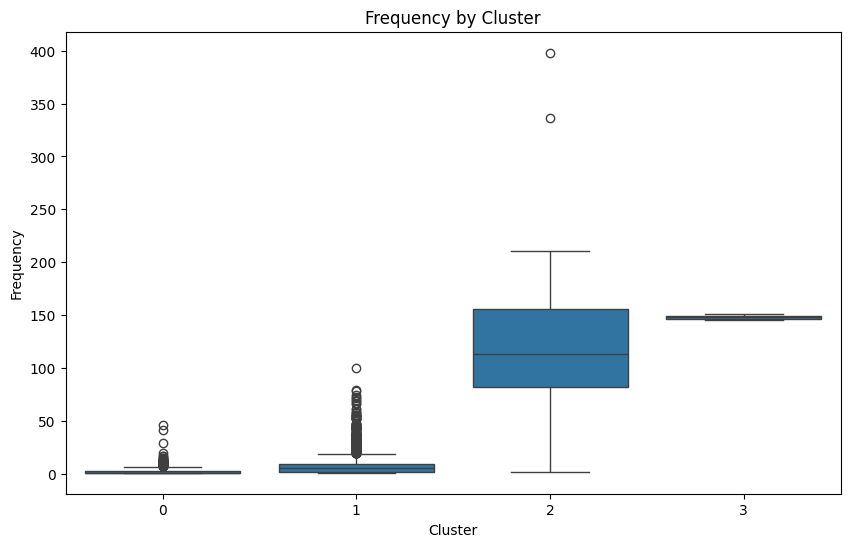

In [34]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Frequency', data=rfm)
plt.title('Frequency by Cluster')
plt.show()

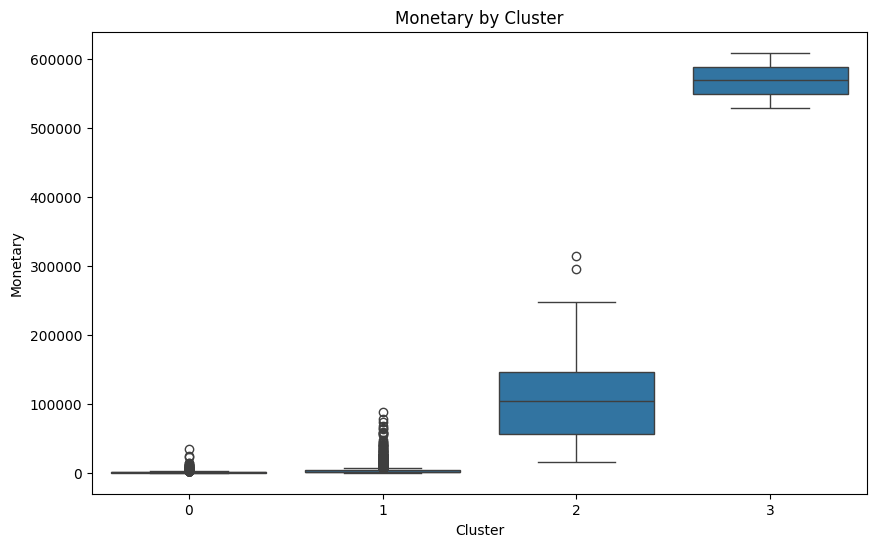

In [35]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Monetary', data=rfm)
plt.title('Monetary by Cluster')
plt.show()

In [36]:
#  Step 8: Business Insights
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)
print("\nCluster Summary:\n")
print(cluster_summary)


Cluster Summary:

        Recency Frequency  Monetary      
           mean      mean      mean count
Cluster                                  
0         462.0       2.2     765.0  2008
1          66.4       7.5    3133.2  3842
2          21.2     131.9  116621.8    26
3           1.5     148.0  568712.1     2


In [22]:
#  Step 9: Export Results
rfm.to_csv('rfm_customer_segments.csv')